# AB2018 Derin Öğrenme Kursu - Doğrusal Model Örneği

Bu örnekte Tensorflow ile basit bir doğrusal model oluşturarak, MNIST verisetinde temel bir sınıflandırma örneği yapacağız. İlk iş olarak, gerekli paketleri içe aktarıyoruz.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

Ardından MNIST verisetini internetten indirmemiz ve klasöre açmamız lazım. **one_hot=True** adlı anahtar kelime (keyword) argümanıyla, verisetindeki etiketlerin hepsini vektörleştiriyoruz. (İndirme işlemi bir kere tamamlandıktan sonra, aynı klasörden bir daha indirmeden okuyacaktır.)

In [2]:
mnist = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Burada resimleri göstermek için basit bir yardımcı fonksiyon oluşturdum. 784 elemanlı vektörü 28x28 boyutunda bir matrise çevirip **plt.imshow** ile gösteriyoruz. Fonksiyonda kullandığımız **cmap** adlı argümanla, renk haritalaması yapıyoruz. Bu şekilde 0'a en yakın değerler beyaz, 1'e en yakın değerler de siyah olacak.

In [3]:
def show_digit(pixels):
    img = pixels.reshape(28, 28)
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')

Daha önceden içe aktardığımız **random** kütüphanesindeki, **sample** fonksiyonu ile verisetinden rastgele bir resim seçip ekranda gösteriyoruz.

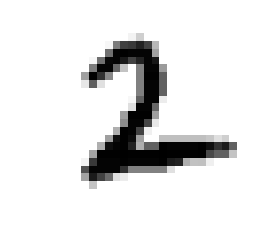

In [4]:
sample = random.choice(mnist.train.images)

show_digit(sample)

Verisetinde ne kadar örnek olduğuna bakalım:

In [5]:
print(u"Eğitim veriseti boyutu: %d örnek" % len(mnist.train.images))
print(u"Test veriseti boyutu: %d örnek" % len(mnist.test.images))

Eğitim veriseti boyutu: 55000 örnek
Test veriseti boyutu: 10000 örnek


Şimdi Tensorflow hesap grafını oluşturmaya başlayabiliriz. Öncelikle veri girişini yapacağımız noktalar için, yer tutucu (placeholder) nesnelerini oluşturuyoruz. Bu değişkenlerin içinde bir veri olmayacak. Hesaplama yapmak istediğimiz zaman dışarıdan veri ile besleyeceğiz.

**tf.float32** ile yer tutucunun hangi veritipinde olacağını belirledik. Sonraki parametre ise boyutları tanımlıyor. Örnek olarak **X** yer tutucusuna, matris boyutunu **[None, 784]** olarak verdiğimizde bu şu anlama gelecek: Herhangi bir satır sayısında, 784 sütunluk veri girişi olacak. Aynısı **y** için de geçerli.

In [6]:
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

Şimdi ise optimize edilecek değişkenleri oluşturmamız lazım. Bunun için **tf.Variable** kullanıyoruz (variable=değişken). Başlangıç için **W (weight)** değişkenine rastgele değerler verdik. Bunun için 0 ile 1 arasında normal dağılıma sahip değerler oluşturduk. **stddev=0.1** ile değer kümesi 0.1'lik standart bir sapmaya sahip olacak. **b (bias)** değişkenine ise **0.1**'lik sabit başlangıç değerleri verdik.

In [7]:
W = tf.Variable(tf.truncated_normal(shape=[784, 10], stddev=0.1))
b = tf.Variable(tf.constant(shape=[10], value=0.1))

Ardından tahmin işlemini gerçekleştirecek hesap grafını oluşturmamız lazım. Doğrusal model tanımı gereği, herhangi bir gizli katman olmayacak. Doğrudan **logit (X * W + b)** değerini hesaplayıp, **softmax** aktivasyon fonksiyonuna vereceğiz.

**y_pred**'i hesaplama için kullandığımızda, artık her bir girdi için bize 10 elemanlı bir vektör döndürecek. Bu vektörün elemanları da toplamı 1'e eşit olan olasılık değerleri olacak. Yani girdiler için olasılık tahminlerini hesaplayacak.

In [8]:
y_pred = tf.nn.softmax(tf.matmul(X, W) + b)

Sonraki adımda, tahmin fonksiyonumuzun ne kadar başarısız olduğunu ölçen bir fonksiyon oluşturmamız gerekiyor. Bu fonksiyon ne kadar yüksek değer üretirse, modelimiz o kadar kötü anlamına gelecek. Bu fonksiyona genellikle kayıp (loss) veya maliyet (cost) denmekte.

Kayıp fonksiyonunu oluşturmak için en basit yöntem, ortalama kareli hata (MSE) hesabı. Ama bunun yerine, çapraz entropi (cross entropy) hesabı yapacağız. Bu hesap için gerekli formül şu şekilde:

$$L = -\sum y' * log(y)$$

Buradaki **y'** gerçek y değerlerini, **y** ise tahmin edilen değerleri ifade ediyor. Aynı fonksiyonu Tensorflow'da oluşturuyoruz.

In [9]:
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred),
                                     reduction_indices=[1]))

Oluşturduğumuz kayıp (loss) fonksiyonunu, otomatik eğim (türev) hesaplarıyla minimize etmesi için bir sistem kullanmamız gerekiyor. Bunun için Tensorflow kütüphanesinde hazır gelen **GradientDescentOptimizer** adlı optimizasyon aracını kullanacağız. Verdiğimiz **0.05** değerindeki argüman, bu sistem için öğrenme katsayısı (learning rate) olacak. Ve son olarak bu optimizasyon sistemine, kayıp fonksiyonunu minimize etmesini söylüyoruz.

Eğitim süreci boyunca sürekli kayıp fonksiyonu hesaplanacak. Bu fonksiyondan gelen değerler üzerinde, daha önce tanımladığımız değişkenler (tf.Variable) ile eğim (türev) hesabı yapılacak. Bu eğim değerleri, öğrenme katsayısı ile ölçeklenip değişkenlerin üzerine eklenecek. Bu şu anlama geliyor: **optimizer** adlı grafı her çalıştırdığımızda, kayıp fonksiyonu hesaplanacak, ardından da **tf.Variable** olarak tanımladığımız ve hesapta kullandığımız tüm değişkenler otomatik olarak eğimlere göre modifiye edilecek.

In [10]:
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Eğitim süreci boyunca, sistemin hassasiyetini hesaplamak için **accuracy** adlı grafı oluşturuyoruz.

In [11]:
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(y_pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

Tüm bu tanımlamalardan sonra, bir Tensorflow oturumu (session) oluşturmamız gerekiyor. Yapacağımız tüm hesaplamalar, bu oturumda gerçekleşecek. Değişkenlerin ilk değerlerinin oluşturulması için de **tf.global_variables_initializer()**'ı kullandık.

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Eğitime başlamadan önce, içeride kullandığım bazı değerleri açıklamakta fayda var. Eğitim (optimizasyon) işlemini, **10000** defa yapıyoruz. Her bir adım, değişkenler üzerinde oldukça küçük değişiklikler yapacak.

Her bir döngüde, verisetinin eğitim kısmından **128** adet örnek alıyoruz. Bu değere genellikle **batch** deniyor (kelime anlamı "yığın, grup, küme vs."). Her seferinde teker teker değil de, grup olarak örnekleri kullanmamızın sebebi çoğunlukla performans odaklı. Bilgisayarın işlem gücü ve bant genişliği kapasitesine göre bu değeri değiştirmek, eğitimin daha hızlı gerçekleşmesini sağlayacak.

Eğitim işleminin gerçekleşmesi için Tensorflow oturumu üzerinde, **optimizer** grafının çalıştırılması lazım. Bu grafın da hesap yapabilmesi için, içinde tanımlı yer tutuculara (X ve y) dışarıdan gerçek değer veriyoruz. Tensorflow jargonuyla ifade etmek gerekirse: Veriyle besliyoruz.

In [13]:
for i in xrange(10000):
    xs, ys = mnist.train.next_batch(128)
    
    _, batch_loss, batch_acc = sess.run([optimizer, loss, accuracy], feed_dict={X: xs, y: ys})
    
    if i % 500 == 0:
        print("[*] Adım: %d, batch kaybı: %.6f, batch hassasiyeti: %.2f%%" % (i, batch_loss, batch_acc * 100))



[*] Adım: 0, batch kaybı: 2.486425, batch hassasiyeti: 10.94%
[*] Adım: 500, batch kaybı: 0.428686, batch hassasiyeti: 91.41%
[*] Adım: 1000, batch kaybı: 0.438087, batch hassasiyeti: 85.94%
[*] Adım: 1500, batch kaybı: 0.306229, batch hassasiyeti: 89.06%
[*] Adım: 2000, batch kaybı: 0.274264, batch hassasiyeti: 92.97%
[*] Adım: 2500, batch kaybı: 0.439294, batch hassasiyeti: 87.50%
[*] Adım: 3000, batch kaybı: 0.398824, batch hassasiyeti: 89.84%
[*] Adım: 3500, batch kaybı: 0.353387, batch hassasiyeti: 92.19%
[*] Adım: 4000, batch kaybı: 0.315770, batch hassasiyeti: 90.62%
[*] Adım: 4500, batch kaybı: 0.306075, batch hassasiyeti: 92.19%
[*] Adım: 5000, batch kaybı: 0.283485, batch hassasiyeti: 90.62%
[*] Adım: 5500, batch kaybı: 0.338506, batch hassasiyeti: 90.62%
[*] Adım: 6000, batch kaybı: 0.276051, batch hassasiyeti: 89.84%
[*] Adım: 6500, batch kaybı: 0.310165, batch hassasiyeti: 89.84%
[*] Adım: 7000, batch kaybı: 0.327720, batch hassasiyeti: 92.19%
[*] Adım: 7500, batch kaybı: 

Eğitim tamamlanmış oldu. Şimdi verisetinin test bölümünde ne kadar hassasiyete ulaşacağına bakalım.

In [14]:
train_acc = sess.run(accuracy, feed_dict={X: mnist.train.images, y: mnist.train.labels})
test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})
print(u"Eğitim hassasiyeti: %.2f%%, Test hassasiyeti: %.2f%%" % (train_acc * 100, test_acc * 100))

Eğitim hassasiyeti: 92.00%, Test hassasiyeti: 92.06%


Sonuçlar basit bir doğrusal model için fena değil. Modeli elle test edip, sonuçları ekrana yazdıralım. Aşağıdaki kod hücresinde, her seferinde verisetinin test bölümünden rastgele bir resim seçeceğiz ve modelden sınıflandırma tahminleri alacağız.

Resmin 0 olma ihtimali: 0.00%
Resmin 1 olma ihtimali: 0.00%
Resmin 2 olma ihtimali: 0.04%
Resmin 3 olma ihtimali: 0.01%
Resmin 4 olma ihtimali: 0.00%
Resmin 5 olma ihtimali: 0.00%
Resmin 6 olma ihtimali: 0.00%
Resmin 7 olma ihtimali: 99.15%
Resmin 8 olma ihtimali: 0.01%
Resmin 9 olma ihtimali: 0.79%


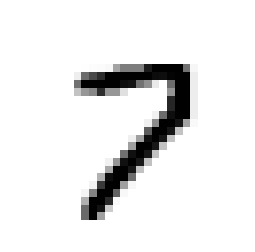

In [15]:
sample = random.choice(mnist.test.images)

predictions = sess.run(y_pred, feed_dict={X: [sample] })[0]

for i, v in enumerate(predictions):
    print(u"Resmin %d olma ihtimali: %.2f%%" % (i, v * 100))
    
show_digit(sample)

Modelin ürettiği 10 elemanlı vektör, resim her bir sınıfa ait olma olasılığını gösteriyor. Bu olasılık değerine genellikle **confidence** (kelime anlamı özgüven) denir. Confidence değerinin belirli bir değerin altında olması (çözülecek probleme göre) yapılan tahminin başarısız olduğunu gösterebilir.

Bu durumu anlamanın en iyi yolu, modele rakam olmayan bir resim vermek. Modele böyle bir resim verirsek, ortaya çıkan olasılıklar belirli sınıflar için birbirlerine yakın olacak. Bu da bize, modelin bu tahmin konusunda başarılı olmadığını gösterecek.

Resmin 0 olma ihtimali: 0.13%
Resmin 1 olma ihtimali: 0.00%
Resmin 2 olma ihtimali: 95.86%
Resmin 3 olma ihtimali: 2.50%
Resmin 4 olma ihtimali: 0.00%
Resmin 5 olma ihtimali: 1.41%
Resmin 6 olma ihtimali: 0.00%
Resmin 7 olma ihtimali: 0.00%
Resmin 8 olma ihtimali: 0.11%
Resmin 9 olma ihtimali: 0.00%


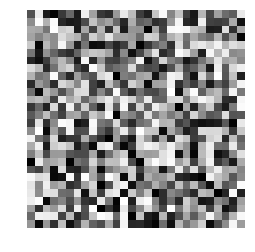

In [16]:
random_img = np.random.rand(784)

predictions = sess.run(y_pred, feed_dict={X: [random_img]})[0]

for i, v in enumerate(predictions):
    print(u"Resmin %d olma ihtimali: %.2f%%" % (i, v * 100))

show_digit(random_img)

Yukarıdaki örnekte, rastgele sayılarla 28x28 (784 piksel) boyutunda bir resim ürettim. Bu resim herhangi bir rakamı ifade etmiyor. Doğal olarak da modelin ürettiği olasılık değerleri, bazı sınıflarda birbirlerine yakın. Yani model, resmin hangi sınıfa ait olduğu konusunda yüksek olasılıklı bir tahmin yapamıyor.